Maud+ 2017: https://ui.adsabs.harvard.edu/abs/2017MNRAS.467L.120M/abstract

Central source is W33A MM1-Main

https://ui.adsabs.harvard.edu/abs/2018A%26A...619A.107S/abstract

Distance from Reid via POETS above

ALMA archive search:
    https://almascience.eso.org/aq/?result_view=observation&raDec=273.664636%20%20-17.866724,%200.1

Luke Maud has additional data at 0.024" resolution

In [1]:
from astropy import units as u
parallax = 0.396 *u.mas # https://ui.adsabs.harvard.edu/abs/2014ApJ...783..130R/abstract
#distance = 3.8 * u.kpc # GUESS
distance = (u.au / parallax).to(u.kpc, u.dimensionless_angles())
distance

<Quantity 2.52525253 kpc>

In [2]:
cd /orange/adamginsburg/salt/sanhueza/W33A/

/orange/adamginsburg/salt/sanhueza/W33A


In [3]:
ls

big.reg
ipython_log_2021-09-29.py
KCl_v_le_2_stackcube.fits
KCl_v_le_4_stackcube.fits
NaCl_v_le_3_stackcube.fits
small.reg
spectra/
W33A.config8.cont_avg.selfcal_0.5_hogbom.image.fits
W33A.config8.spw0.robust0.5.image_cb_smaller.fits
W33A.config8.spw0.robust0.5.image_small.fits
W33A.config8.spw1.robust0.5.image_cb_smaller.fits
W33A.config8.spw1.robust0.5.image_small.fits
W33A.config8.spw2.robust0.5.image_cb_smaller.fits
W33A.config8.spw2.robust0.5.image_small.fits
W33A.config8.spw3.robust0.5.image_cb_smaller.fits
W33A.config8.spw3.robust0.5.image_small.fits*
W33A.zip


In [4]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2ae8034de790>

In [5]:
from astropy.table import Table
from astropy import table

In [6]:
import pprint

In [7]:
import scipy, scipy.ndimage

In [8]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord, visualization
import radio_beam
import pyspeckit
import pylab as pl
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [9]:
import regions
from astropy import units as u, coordinates
reg = regions.Regions.read('big.reg')
regsm = regions.Regions.read('small.reg')
#egvsm = regions.Regions.read('sourceAsmaller.reg')
#regvvsm = regions.Regions.read('.reg')

In [10]:
cat small.reg

# Region file format: DS9 CARTA 2.0.0
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
icrs
box(273.664636, -17.866724, 0.5879", 0.6897", 0) # color=#2EE6D6 width=2


In [11]:
cat big.reg

# Region file format: DS9 CARTA 2.0.0
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
icrs
box(273.664636, -17.866724, 2.0", 2.0", 0) # color=#2EE6D6 width=2



(2277.0, 2518.0, 2521.0, 2762.0)

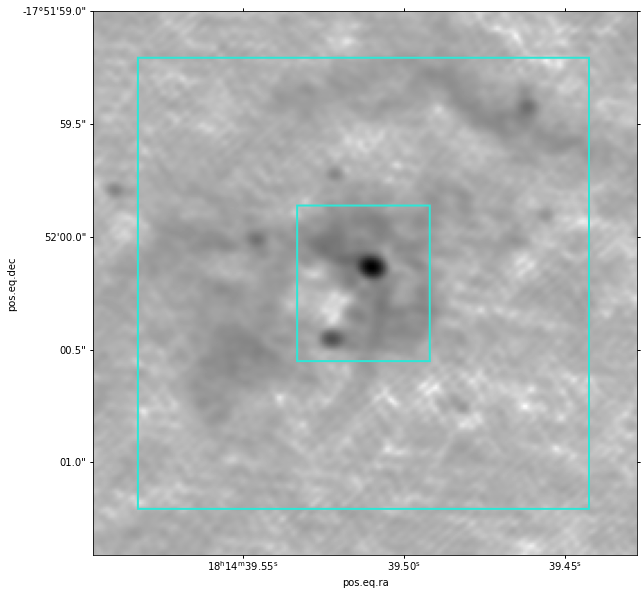

In [12]:
cont = SpectralCube.read('W33A.config8.cont_avg.selfcal_0.5_hogbom.image.fits')
pl.figure(figsize=(10,10))
ax = pl.subplot(projection=cont[0].wcs)
ax.imshow(cont[0].value, cmap='gray_r', norm=visualization.simple_norm(cont[0].value, stretch='log'))
reg[0].to_pixel(cont[0].wcs).plot(ax=ax)
regsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
#regvsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
#regvvsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
pp = reg[0].to_pixel(cont.wcs.celestial)
bb = pp.bounding_box
ax.axis([bb.ixmin-20, bb.ixmax+20, bb.iymin-20, bb.iymax+20])

# NaCl Stackl

In [13]:
from spectral_cube.analysis_utilities import stack_cube

In [14]:
nacltables = salt_tables[3:5]
#nacltables[0]

In [15]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [16]:
flist = sorted(glob.glob('W33A.config8.spw[0-3].robust0.5.image_small.fits'))

In [17]:
import dask
dask.config.set(scheduler='threads', num_workers=8)

In [18]:
for fn in flist:
    outfile = fn.replace("_small","_cb_smaller")
    if not os.path.exists(outfile) or SpectralCube.read(outfile).unit != u.K:
        cube = SpectralCube.read(fn, use_dask=True).subcube_from_regions(reg)
        print(cube)
        cube.allow_huge_operations=True
        cb = cube.beams.common_beam(max_iter=20, max_epsilon=0.01)
        scube = cube.convolve_to(cb)
        scube.allow_huge_operations=True
        scube.to(u.K).write(outfile, overwrite=True)

DaskVaryingResolutionSpectralCube with shape=(1931, 200, 193) and unit=Jy / beam and chunk size (322, 104, 171):
 n_x:    193  type_x: RA---SIN  unit_x: deg    range:   273.664346 deg:  273.664907 deg
 n_y:    200  type_y: DEC--SIN  unit_y: deg    range:   -17.867000 deg:  -17.866447 deg
 n_s:   1931  type_s: FREQ      unit_s: Hz     range: 233562367862.000 Hz:235447230123.057 Hz


DaskVaryingResolutionSpectralCube with shape=(1930, 200, 193) and unit=Jy / beam and chunk size (193, 104, 171):
 n_x:    193  type_x: RA---SIN  unit_x: deg    range:   273.664346 deg:  273.664907 deg
 n_y:    200  type_y: DEC--SIN  unit_y: deg    range:   -17.867000 deg:  -17.866447 deg
 n_s:   1930  type_s: FREQ      unit_s: Hz     range: 231062373964.100 Hz:232946259612.704 Hz


DaskVaryingResolutionSpectralCube with shape=(3860, 200, 193) and unit=Jy / beam and chunk size (193, 104, 171):
 n_x:    193  type_x: RA---SIN  unit_x: deg    range:   273.664346 deg:  273.664907 deg
 n_y:    200  type_y: DEC--SIN  unit_y: deg    range:   -17.867000 deg:  -17.866447 deg
 n_s:   3860  type_s: FREQ      unit_s: Hz     range: 216862164470.600 Hz:218746538425.725 Hz


DaskVaryingResolutionSpectralCube with shape=(3860, 200, 193) and unit=Jy / beam and chunk size (193, 104, 171):
 n_x:    193  type_x: RA---SIN  unit_x: deg    range:   273.664346 deg:  273.664907 deg
 n_y:    200  type_y: DEC--SIN  unit_y: deg    range:   -17.867000 deg:  -17.866447 deg
 n_s:   3860  type_s: FREQ      unit_s: Hz     range: 219062159100.800 Hz:220946533055.454 Hz


In [19]:
cbflist = sorted((glob.glob('W33A.config8.spw[0-3].robust0.5.image_cb_smaller.fits')))
cubes = [SpectralCube.read(fn, use_dask=True).subcube_from_regions(regsm) for fn in cbflist]
cubes

[DaskSpectralCube with shape=(1931, 69, 59) and unit=K and chunk size (434, 69, 59):
  n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
  n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
  n_s:   1931  type_s: FREQ      unit_s: Hz     range: 233562367862.000 Hz:235447230123.057 Hz,
 DaskSpectralCube with shape=(1930, 69, 59) and unit=K and chunk size (386, 69, 59):
  n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
  n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
  n_s:   1930  type_s: FREQ      unit_s: Hz     range: 231062373964.100 Hz:232946259612.704 Hz,
 DaskSpectralCube with shape=(3860, 69, 59) and unit=K and chunk size (386, 69, 59):
  n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
  n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
  n_s:   3860  type

In [20]:
# only needed for VRSCs
if hasattr(cubes[0], 'beams'):
    beams = radio_beam.Beams(beams=[cube.beams.common_beam(max_iter=20, max_epsilon=0.01) for cube in cubes])
    cb=beams.common_beam()
else:
    cb = cubes[0].beam

In [21]:
cb

Beam: BMAJ=0.09669544547796216 arcsec BMIN=0.06535904854536036 arcsec BPA=-83.22697448730469 deg

In [22]:
(cb.major*distance).to(u.au, u.dimensionless_angles())

<Quantity 244.18041787 AU>

In [23]:
(cb.minor*distance).to(u.au, u.dimensionless_angles())

<Quantity 165.04810239 AU>

In [24]:
linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 219.614936, 232.509977, 234.251912] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=1-1 J=17-16',
        '23Na-35Clv=1-1 J=18-17', '23Na-35Clv=0-0 J=18-17'], dtype='<U24'))

In [25]:
from astropy import log
log.setLevel('INFO')

In [26]:
cubes

[DaskSpectralCube with shape=(1931, 69, 59) and unit=K and chunk size (434, 69, 59):
  n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
  n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
  n_s:   1931  type_s: FREQ      unit_s: Hz     range: 233562367862.000 Hz:235447230123.057 Hz,
 DaskSpectralCube with shape=(1930, 69, 59) and unit=K and chunk size (386, 69, 59):
  n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
  n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
  n_s:   1930  type_s: FREQ      unit_s: Hz     range: 231062373964.100 Hz:232946259612.704 Hz,
 DaskSpectralCube with shape=(3860, 69, 59) and unit=K and chunk size (386, 69, 59):
  n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
  n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
  n_s:   3860  type

In [27]:
#log.setLevel('DEBUG')
vcen = 35 * u.km/u.s # from Patricio
stack, cutouts = stack_cube(cubes,
                   linelist=linelist,
                   vmin=vcen-30*u.km/u.s,
                   vmax=vcen+30*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack.write('NaCl_v_le_3_stackcube.fits', overwrite=True)

In [28]:
stackc = SpectralCube.read('NaCl_v_le_3_stackcube.fits')
stackc

SpectralCube with shape=(90, 69, 59) and unit=K:
 n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
 n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
 n_s:     90  type_s: VRAD      unit_s: km / s  range:        5.160 km / s:      64.930 km / s

invalid value encountered in true_divide


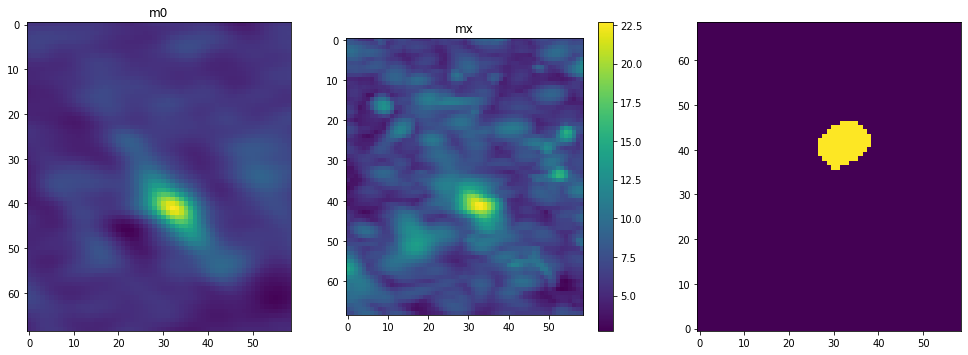

<Figure size 432x288 with 0 Axes>

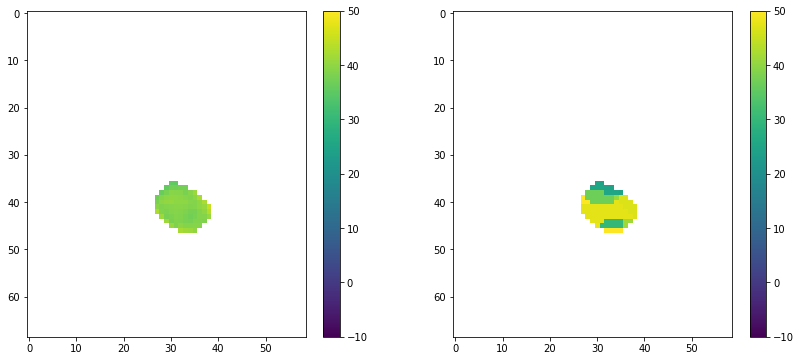

In [29]:
stackc = stackc.subcube_from_regions(regsm)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackc.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = stackc.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 15*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=3)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()



from dask_image.ndmorph import binary_dilation, binary_erosion
from scipy.ndimage import binary_dilation, binary_erosion
m3d = (stackc > 10*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
#m3d = m3d.compute()



m1 = stackc.with_mask(msk).with_mask(m3d).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-10, vmax=50)
pl.colorbar(mappable=im)
mxv = stackc.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=-10, vmax=50)
pl.colorbar()


vmap = m1.hdu

DaskSpectralCube with shape=(1930, 69, 59) and unit=K and chunk size (386, 69, 59):
 n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
 n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
 n_s:   1930  type_s: FREQ      unit_s: Hz     range: 231062373964.100 Hz:232946259612.704 Hz
DaskSpectralCube with shape=(32, 69, 59) and unit=K and chunk size (32, 69, 59):
 n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
 n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
 n_s:     32  type_s: VRAD      unit_s: km / s  range:       15.382 km / s:      54.388 km / s


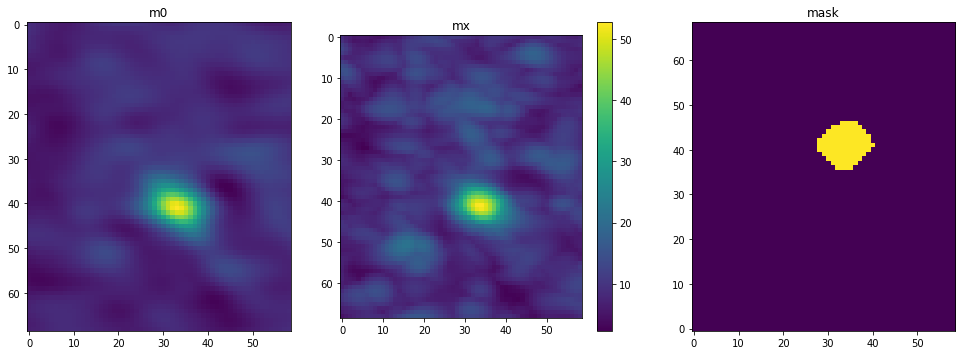

<Figure size 432x288 with 0 Axes>

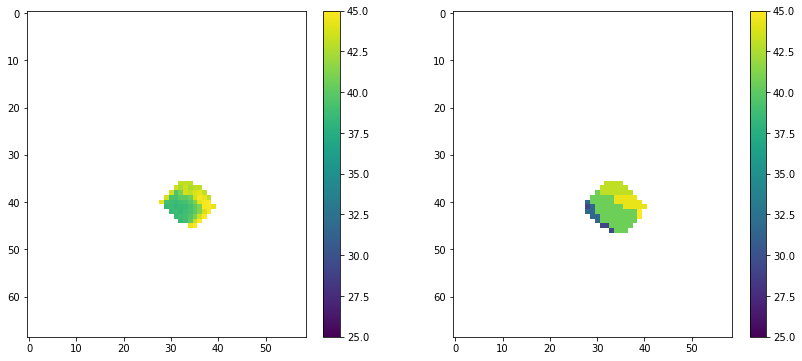

In [30]:
# try creating a vmap based on another line (water)
restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
cube = [c for c in cubes if (c.with_spectral_unit(u.GHz).spectral_extrema[0] < restval) & (c.with_spectral_unit(u.GHz).spectral_extrema[1] > restval)][0]
print(cube)
scube = (cube.subcube_from_regions(regsm)
         .with_spectral_unit(u.GHz)
         .with_spectral_unit(u.km/u.s,
                             velocity_convention='radio',
                             rest_value=restval)
         .spectral_slab(-20*u.km/u.s+vcen, 20*u.km/u.s+vcen))
print(scube)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 35*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=3)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()

from dask_image.ndmorph import binary_dilation, binary_erosion
m3d = (scube > 30*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
m3d = m3d.compute()

m1 = scube.with_mask(msk).with_mask(m3d).moment1()
m0m = scube.with_mask(msk).with_mask(m3d).moment0()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-10, vmax=vcen.value+10)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-10, vmax=vcen.value+10)
pl.colorbar()

#pl.figure()
#pl.imshow(m0m.value)
#m0m.hdu.writeto('water_masked_moment0.fits', overwrite=True)

vmap = m1.hdu

In [31]:
import sys
sys.path.append('/orange/adamginsburg/salt/code/')
from overplot_saltlines import overplot_saltlines

In [32]:
spectra = []
for ii,cube in enumerate(cubes):
    cube.allow_huge_operations=True
    sp = cube.subcube_from_regions(regsm).mean(axis=(1,2))
    pysp = pyspeckit.Spectrum(data=sp, xarr=sp.spectral_axis, header=sp.header)
    spectra.append(pysp)
    pysp.specname = f'spw{ii+1}'

In [33]:
mkdir -p spectra/figures

spw1
spw2


spw3
spw4


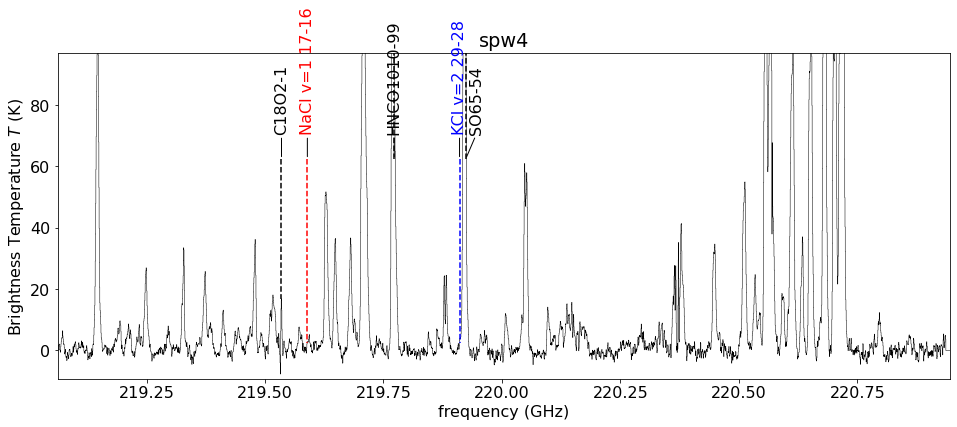

In [34]:
overplot_saltlines(spectra, vcen=vcen, savepath='spectra/figures')

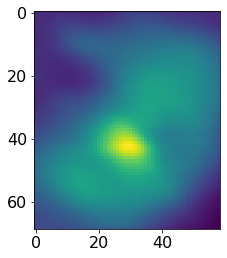

In [35]:
m0ch3cn = cubes[-1].spectral_slab(220.5*u.GHz, 220.65*u.GHz).moment0()
m0ch3cn.quicklook()

In [36]:
ls spectra/figures

color_labels_spw1.png
color_labels_spw2.png
color_labels_spw3.png
color_labels_spw4.png
color_labels_W33A.config8.spw0_5_stack.png
color_labels_W33A.config8.spw1_5_stack.png
color_labels_W33A.config8.spw2_5_stack.png
color_labels_W33A.config8.spw3_5_stack.png
gallery.html
spw1.png
spw2.png
spw3.png
spw4.png
style.css
W33A.config8.spw0_5_stack.png
W33A.config8.spw0.robust0.5.image_cb_smaller_stack.pdf
W33A.config8.spw0.robust0.5.image_cb_smaller_stack.png
W33A.config8.spw1_5_stack.png
W33A.config8.spw1.robust0.5.image_cb_smaller_stack.pdf
W33A.config8.spw1.robust0.5.image_cb_smaller_stack.png
W33A.config8.spw2_5_stack.png
W33A.config8.spw2.robust0.5.image_cb_smaller_stack.pdf
W33A.config8.spw2.robust0.5.image_cb_smaller_stack.png
W33A.config8.spw3_5_stack.png
W33A.config8.spw3.robust0.5.image_cb_smaller_stack.pdf
W33A.config8.spw3.robust0.5.image_cb_smaller_stack.png


In [37]:
from IPython.display import Image,display

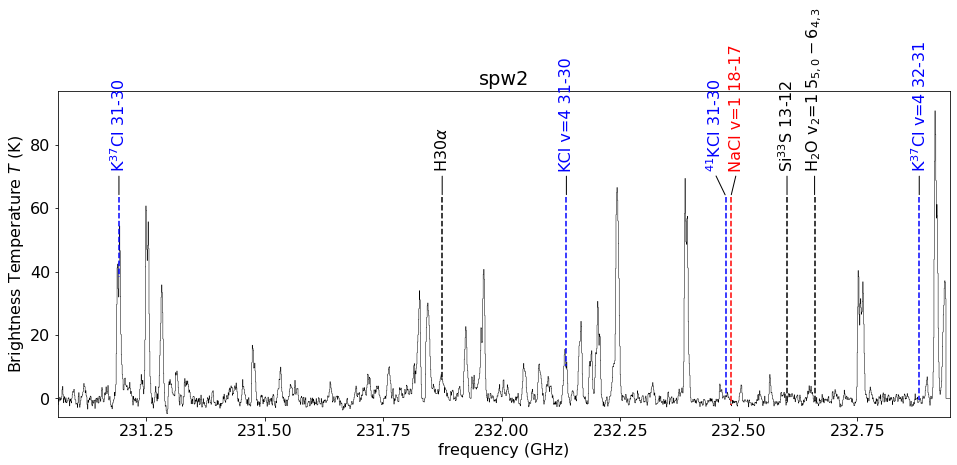

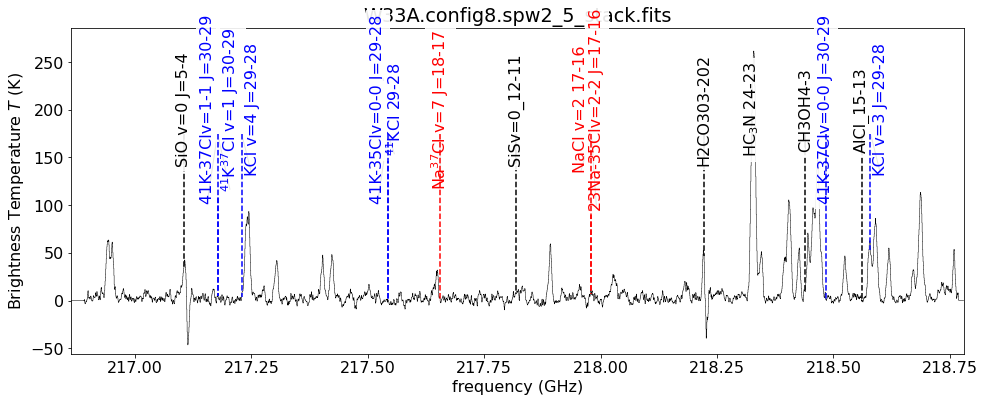

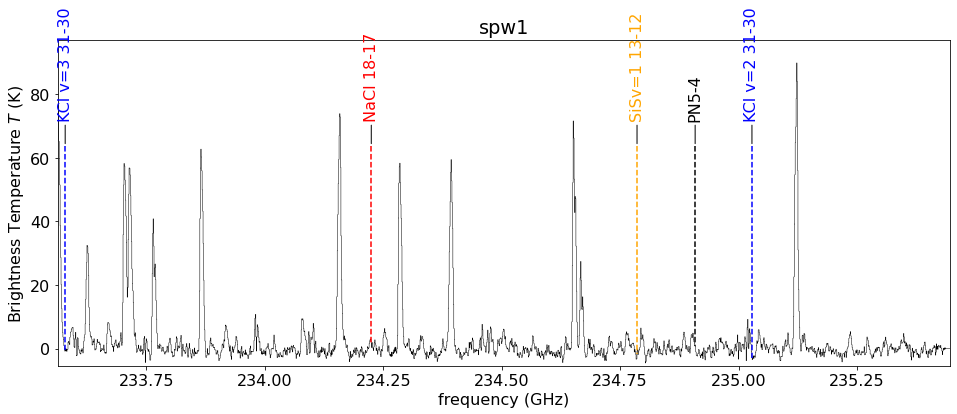

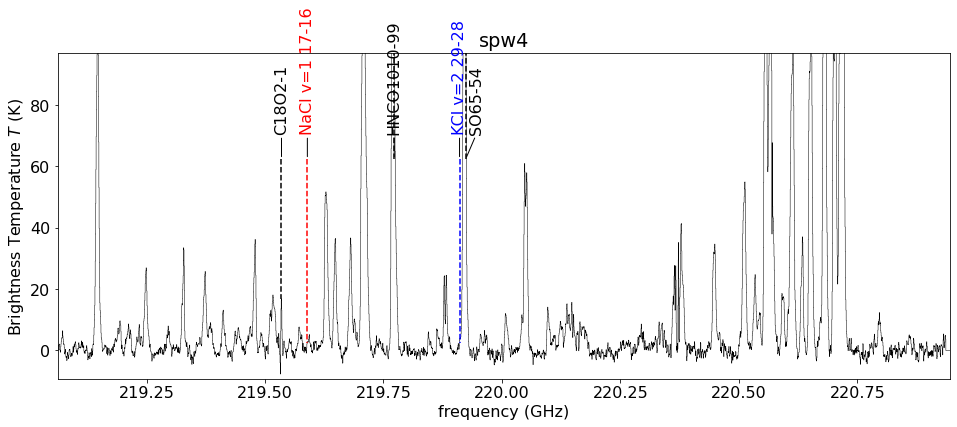

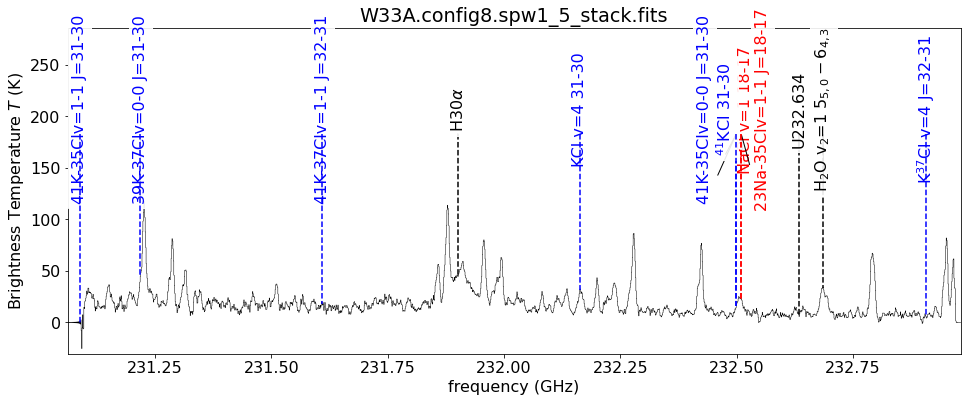

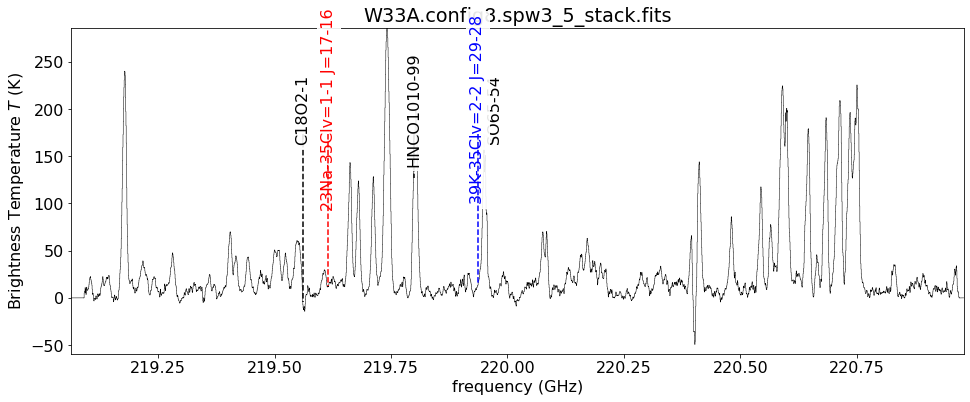

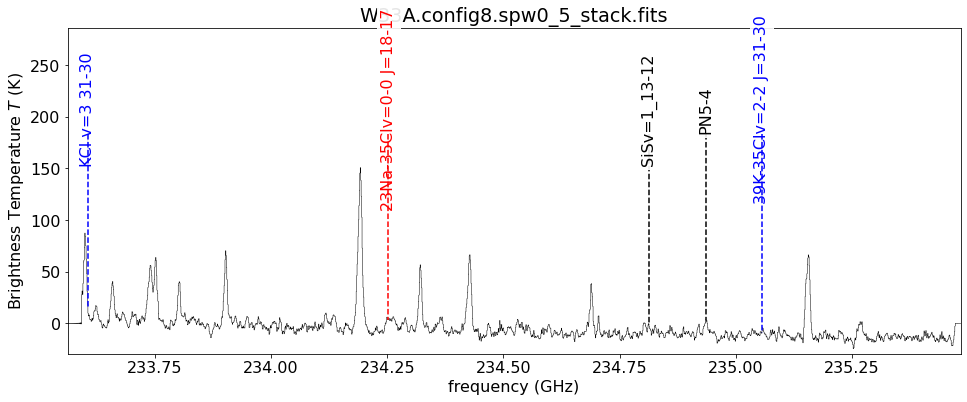

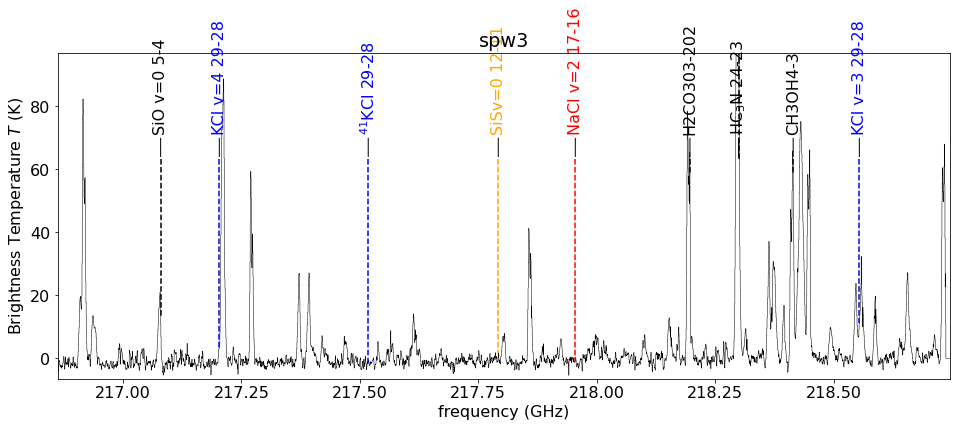

In [38]:
for fn in glob.glob('spectra/figures/color*png'):
    display(Image(fn))

DaskSpectralCube with shape=(1931, 200, 193) and unit=K and chunk size (434, 200, 193):
 n_x:    193  type_x: RA---SIN  unit_x: deg    range:   273.664346 deg:  273.664907 deg
 n_y:    200  type_y: DEC--SIN  unit_y: deg    range:   -17.867000 deg:  -17.866447 deg
 n_s:   1931  type_s: FREQ      unit_s: Hz     range: 233562367862.000 Hz:235447230123.057 Hz
Mean spectrum
Stacking
DaskSpectralCube with shape=(1930, 200, 193) and unit=K and chunk size (386, 200, 193):
 n_x:    193  type_x: RA---SIN  unit_x: deg    range:   273.664346 deg:  273.664907 deg
 n_y:    200  type_y: DEC--SIN  unit_y: deg    range:   -17.867000 deg:  -17.866447 deg
 n_s:   1930  type_s: FREQ      unit_s: Hz     range: 231062373964.100 Hz:232946259612.704 Hz
Mean spectrum
Stacking
DaskSpectralCube with shape=(3860, 200, 193) and unit=K and chunk size (386, 200, 193):
 n_x:    193  type_x: RA---SIN  unit_x: deg    range:   273.664346 deg:  273.664907 deg
 n_y:    200  type_y: DEC--SIN  unit_y: deg    range:   -17.86

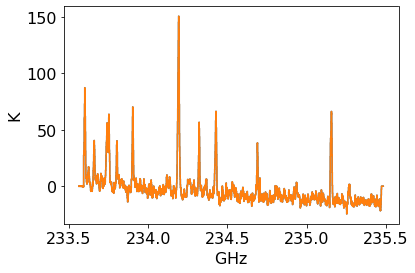

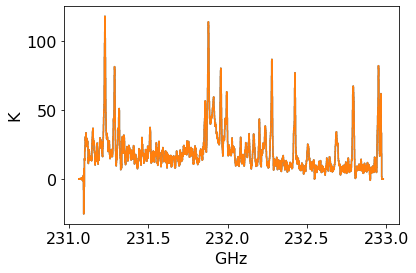

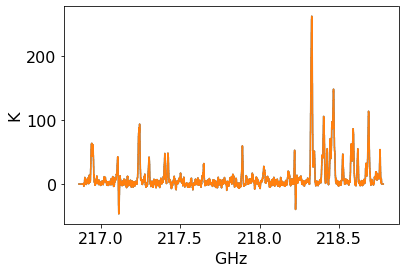

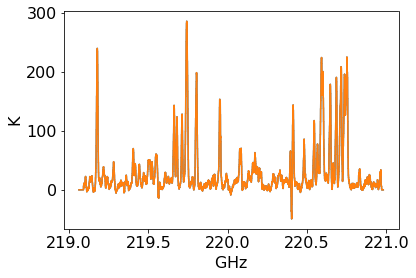

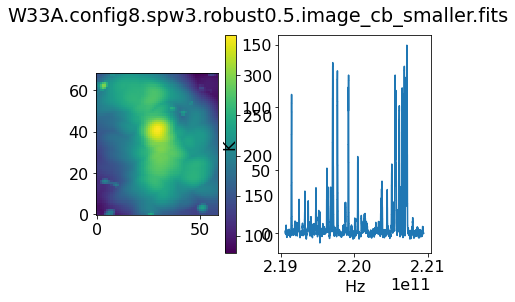

In [39]:
import glob
import spectral_cube.analysis_utilities
import reproject
from tqdm.notebook import tqdm

for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions(regsm)
    mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)

    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           #progressbar=tqdm,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

In [40]:
ls spectra

figures/
W33A.config8.spw0.robust0.5.image_cb_smaller_meanspec.fits
W33A.config8.spw0.robust0.5.image_cb_smaller_stack.fits
W33A.config8.spw1.robust0.5.image_cb_smaller_meanspec.fits
W33A.config8.spw1.robust0.5.image_cb_smaller_stack.fits
W33A.config8.spw2.robust0.5.image_cb_smaller_meanspec.fits
W33A.config8.spw2.robust0.5.image_cb_smaller_stack.fits
W33A.config8.spw3.robust0.5.image_cb_smaller_meanspec.fits
W33A.config8.spw3.robust0.5.image_cb_smaller_stack.fits


In [ ]:
stackspectra = []
for ii,fn in enumerate(glob.glob('spectra/*_stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'W33Amm1 {fn.split(".")[2]} stack'
    print(pysp.specname)
    stackspectra.append(pysp)

In [ ]:
overplot_saltlines(stackspectra, vcen=0*u.km/u.s, savepath='spectra/figures', ymax=300, yfrac=0.6)

In [ ]:
ls spectra/figures/

In [ ]:
for fn in glob.glob('spectra/figures/color*spw[0-4]_stack.png'):
    display(Image(fn))

In [45]:
# table 5 is double-rare, not detected

kcltables = salt_tables[:3]#  + salt_tables[5:]

# cubes are already loaded
# cubes = [SpectralCube.read(fn).subcube_from_regions([reg]) for fn in (glob.glob('G17_SPW[0-3]_2017.image.fits'))]
# beams = radio_beam.Beams(beams=[cube.beams.common_beam() for cube in cubes])
# cb=beams.common_beam()
linelistK = np.concatenate([data['Freq'][(data['vu'] <= 4) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in kcltables])
linenamesK = np.concatenate( [data['Species'][(data['vu'] <= 4) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in kcltables] )
print(linelistK, linenamesK)
rows = [data[(data['vu'] <= 4) &
             np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                      (data['Freq'].quantity < cube.spectral_extrema[1]))
                     for cube in cubes],
                    axis=0)]
        for data in kcltables]
KCl_inband = table.vstack(rows)
print(KCl_inband)

# exclude lines with contaminants
# 41KCl v=4 J=30-20 is the worst, apparently, b/c of NaCl v=1 17-16
# 41KCl v=0 J=31-30 is on top of NaCl v=1 18-17
# KCl v=2 29-28 is double-peaked; not clear what's up there
# 41KCl v=0 J=29-28 just looks like a nondetection?
# 39K-37Cl v=4 J=30-29 nondetection
# 39K-37Cl v=3 J=32-31 nondetection
# 41K-35Cl v=1 J=31-30 nondetection
exclude = ('41K-35Clv=0-0 J=31-30',
           '41K-35Clv=4-4 J=30-29',
           '39K-35Clv=2-2 J=29-28',
           '41K-35Clv=0-0 J=29-28',
           '39K-37Clv=4-4 J=30-29',
           '39K-37Clv=3-3 J=32-31',
           '41K-35Clv=1-1 J=31-30',           
          )
incl = np.all([linenamesK != ex for ex in exclude], axis=0)
linelistK = linelistK[incl]
linenamesK = linenamesK[incl]
linelistK, linenamesK
pprint.pprint(dict(zip(linelistK, linenamesK)))

[217.22891176 218.5797076  219.93611261 232.16184646 233.60569798
 235.05557839 218.39656825 219.73475809 231.21883931 232.90755269
 234.33493148 217.54316883 219.59177028 220.941078   231.08814962
 232.49980161 234.18192351] GHz ['39K-35Clv=4-4 J=29-28' '39K-35Clv=3-3 J=29-28' '39K-35Clv=2-2 J=29-28'
 '39K-35Clv=4-4 J=31-30' '39K-35Clv=3-3 J=31-30' '39K-35Clv=2-2 J=31-30'
 '39K-37Clv=4-4 J=30-29' '39K-37Clv=3-3 J=30-29' '39K-37Clv=0-0 J=31-30'
 '39K-37Clv=4-4 J=32-31' '39K-37Clv=3-3 J=32-31' '41K-35Clv=0-0 J=29-28'
 '41K-35Clv=4-4 J=30-29' '41K-35Clv=3-3 J=30-29' '41K-35Clv=1-1 J=31-30'
 '41K-35Clv=0-0 J=31-30' '41K-35Clv=4-4 J=32-31']
upper_state lower_state    Aij    Frequency_cm        Freq               E_U                E_L              QNs       vu  vl  Ju  Jl  gu   gl         Species       
                          1 / s      1 / cm           GHz                 K                  K                                                                       
----------- -----------

In [46]:
stackK, cutoutsK = stack_cube(cubes,
                   linelist=linelistK,
                   vmin=-60*u.km/u.s,
                   vmax=-5*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
stackK.to(u.K).write('KCl_v_le_4_stackcube.fits', overwrite=True)

In [47]:
stackKc = SpectralCube.read('KCl_v_le_4_stackcube.fits', use_dask=True)
stackKc

DaskSpectralCube with shape=(83, 69, 59) and unit=K and chunk size (83, 69, 59):
 n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
 n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
 n_s:     83  type_s: VRAD      unit_s: km / s  range:      -59.937 km / s:      -4.677 km / s

In [48]:
# table 5 is double-rare, not detected

kcltables = salt_tables[:3]#  + salt_tables[5:]

# cubes are already loaded
# cubes = [SpectralCube.read(fn).subcube_from_regions([reg]) for fn in (glob.glob('G17_SPW[0-3]_2017.image.fits'))]
# beams = radio_beam.Beams(beams=[cube.beams.common_beam() for cube in cubes])
# cb=beams.common_beam()
linelistK = np.concatenate([data['Freq'][(data['vu'] <= 2) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in kcltables])
linenamesK = np.concatenate( [data['Species'][(data['vu'] <= 2) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in kcltables] )
print(linelistK, linenamesK)
rows = [data[(data['vu'] <= 2) &
             np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                      (data['Freq'].quantity < cube.spectral_extrema[1]))
                     for cube in cubes],
                    axis=0)]
        for data in kcltables]
KCl_inband = table.vstack(rows)
print(KCl_inband)

# exclude lines with contaminants
# 41KCl v=4 J=30-20 is the worst, apparently, b/c of NaCl v=1 17-16
# 41KCl v=0 J=31-30 is on top of NaCl v=1 18-17
# KCl v=2 29-28 is double-peaked; not clear what's up there
# 41KCl v=0 J=29-28 just looks like a nondetection?
# 39K-37Cl v=4 J=30-29 nondetection
# 39K-37Cl v=3 J=32-31 nondetection
# 41K-35Cl v=1 J=31-30 nondetection
exclude = ('41K-35Clv=0-0 J=31-30',
           '41K-35Clv=4-4 J=30-29',
           '39K-35Clv=2-2 J=29-28',
           '41K-35Clv=0-0 J=29-28',
           '39K-37Clv=4-4 J=30-29',
           '39K-37Clv=3-3 J=32-31',
           '41K-35Clv=1-1 J=31-30',           
          )
incl = np.all([linenamesK != ex for ex in exclude], axis=0)
linelistK = linelistK[incl]
linenamesK = linenamesK[incl]
linelistK, linenamesK
pprint.pprint(dict(zip(linelistK, linenamesK)))

stackK, cutoutsK = stack_cube(cubes,
                   linelist=linelistK,
                   vmin=-60*u.km/u.s,
                   vmax=-5*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
stackK.to(u.K).write('KCl_v_le_2_stackcube.fits', overwrite=True)

[219.93611261 235.05557839 231.21883931 217.54316883 231.08814962
 232.49980161] GHz ['39K-35Clv=2-2 J=29-28' '39K-35Clv=2-2 J=31-30' '39K-37Clv=0-0 J=31-30'
 '41K-35Clv=0-0 J=29-28' '41K-35Clv=1-1 J=31-30' '41K-35Clv=0-0 J=31-30']
upper_state lower_state    Aij    Frequency_cm        Freq               E_U                E_L              QNs       vu  vl  Ju  Jl  gu   gl        Species       
                          1 / s      1 / cm           GHz                 K                  K                                                                      
----------- ----------- --------- ------------ ------------------ ------------------ ------------------ ------------- --- --- --- --- ---- --- ---------------------
       1033        1032 0.0066713     7.335813 219.93611261476423  953.5558794307203  943.0012778144056 v=2-2 J=29-28   2   2  29  28  944 912 39K-35Clv=2-2 J=29-28
       1035        1034  0.008155     7.840115 235.05557839444083  975.7535062213024  964.4733263078973 v=2-